# Problem Description

- The competition is called : **Corporacion Favorita Grocery Sales Forecasting**.
- The task is to predict sales in the stores of an Ecuadorian supermarket chain so that they can avoid overstocking.
- The given data is a table with the following variables/features: date, store id, item id, sales volume, promotion.
- We can see the data as N time series, one per (store, item) combination. Many of these time series are most likely correlated to each other and some sort of <b>dimensional reduction</b> will be most welcome here. 
- The company also offers some other data sets, such as a list of stores, a time series of daily transactions per store, a list of holidays and events, a list of products by category, and the price of oil, of which a good chunk of the ecuadorian economy is allegedly tied to. These are additional tools to simplify and/or enhance the predictions, and some other external data could also be used in this regard. 

# Set-up

In [1]:
# DATA MANIPULATION
import numpy as np # linear algebra
import random as rd
import pandas as pd # data processing
import datetime # manipulating date formats
from operator import add # elementwise addition

# VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
import seaborn # for prettier plots
#import folium # plotting data on interactive maps
%matplotlib inline

# SUPERVISED LEARNING
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Reading daily transfers per store
sales = pd.read_csv('../input/transactions.csv', parse_dates=['date'])

# Reading store list
stores = pd.read_csv('../input/stores.csv')
stores.type=stores.type.astype('category')

# Reading the holiday and events schedule
holidays=pd.read_csv('../input/holidays_events.csv', parse_dates=['date'])

# Reading oil
oil=pd.read_csv('../input/processed/oil.csv', parse_dates=['date'])

# Merge datasets
def merge_sales(sales):
    sales=pd.merge(sales,stores,how='left')
    sales=pd.merge(sales,oil,how='left')
    return sales

sales = merge_sales(sales)

# Feature engineering

### Date

First, let's work on creating features derived from the date, which is expected to be an important field as we are working with time series

In [3]:
## Some features were not very useful: year,month,day

def add_date_features(df):
    #df['year'] = df['date'].dt.year
    #df['month'] = df['date'].dt.month
    #df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.week
    df['dow'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayoff']=[x in [5,6] for x in df.dow] ## Weekends

add_date_features(sales)
sales.head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico,week,dow,dayofyear,dayoff
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,93.14,1,1,1,False
1,2013-01-02,1,2111,Quito,Pichincha,D,13,93.14,1,2,2,False
2,2013-01-02,2,2358,Quito,Pichincha,D,13,93.14,1,2,2,False
3,2013-01-02,3,3487,Quito,Pichincha,D,8,93.14,1,2,2,False
4,2013-01-02,4,1922,Quito,Pichincha,D,9,93.14,1,2,2,False


### Holiday events
This events are expected to be correlated with high volume sales

In [4]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# Enable all holidays
def enable_holidays(sales):
    for (d,t,l,n) in zip(holidays.date,holidays.type,holidays.locale,holidays.locale_name):
        if t!='Work Day' and t!='Event':  
            if l=='National':
                sales.loc[sales.date==d,'dayoff']=True
            elif l=='Regional':
                sales.loc[(sales.date==d)&(sales.state==n),'dayoff']=True
            else:
                sales.loc[(sales.date==d)&(sales.city==n),'dayoff']=True
        else:
            sales.loc[(sales.date==d),'dayoff']=False

enable_holidays(sales)

In [6]:
## Some manual verifications
sales.loc[lambda df: df.date=='2015-01-10'].head()
#sales.loc[lambda df: (df.date=='2017-04-13') & (df.city=='Cuenca')].head()
#sales.loc[lambda df: (df.date=='2013-04-01') & (df.state=='Cotopaxi')].head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico,week,dow,dayofyear,dayoff
34431,2015-01-10,1,1534,Quito,Pichincha,D,13,47.587,2,5,10,False
34432,2015-01-10,2,2083,Quito,Pichincha,D,13,47.587,2,5,10,False
34433,2015-01-10,3,3601,Quito,Pichincha,D,8,47.587,2,5,10,False
34434,2015-01-10,4,1689,Quito,Pichincha,D,9,47.587,2,5,10,False
34435,2015-01-10,5,1645,Santo Domingo,Santo Domingo de los Tsachilas,D,4,47.587,2,5,10,False


### Transactions


In [7]:
# Transformation
def transform_transactions(sales):
    
    sales['transactions'] = np.log1p(sales.transactions)

transform_transactions(sales)

# Normalized
#sales['transactions3'] = (sales['transactions2'] - sales['transactions2'].mean()) / sales['transactions2'].std()
# Normalize independently 

# Histograms
#plt.figure(figsize=(15,5))
#sales.transactions.hist(ax=plt.subplot(1,3,1))
#sales.transactions2.hist(ax=plt.subplot(1,3,2))
#sales.transactions3.hist(ax=plt.subplot(1,3,3))

In [8]:
# Denormalize
def denormalize_target(sales, target, transform=False):
    target_std = sales['transactions2'].std()
    target_mean = sales['transactions2'].mean()

    out = target * target_std + target_mean
    if transform:
        out = np.expm1(out)
    
    return out
    
#test = denormalize_target(sales, sales.transactions3, True)
#test.hist()

Both distributions are skewed. But the transformed looks more normal

### Categorical features

Use one-hot encoding for city, state, type.
This might create hundreds of features, which could be restricting given the amount of data.

In [9]:
def encode(df, column) -> pd.DataFrame:
    one_hot = pd.get_dummies(df[column], drop_first=False, prefix=column)
    #return (one_hot - one_hot.mean()) / one_hot.std()
    return one_hot

def encode_categorical_features(sales):
    cat_columns = ['store_nbr'] #['store_nbr','city', 'state', 'type']
    
    for column in cat_columns:
        column_enc = encode(sales, column)
        sales = pd.concat([sales,column_enc], axis=1)
    
    return sales


sales = encode_categorical_features(sales)

In [10]:
print_cols = [c for c in sales.columns if 
             not c.startswith('store_nbr_') and 
             not c.startswith('city_') and 
             not c.startswith('state') and 
             not c.startswith('type_')]

### Check the missing data

This is necessary in this point, because in the next step a lot of rows will be injected to provide complete time series.

In [11]:
md = [(c,sales[c].isnull().sum()) for c in sales.columns]

for a in md:
    if a[1]>0:
        print(a)

There is no missing data

### Lagged features: weekly and annual

In [12]:
#u_dates = sales.date.unique() # There are no records for some dates (eg: 25-dic)
dates_range =  pd.date_range(sales.date.min(), sales.date.max())
u_stores = sales.store_nbr.unique()

def add_lag_features(sales):
    ''' 
    Creates two lags features: 
    - lag_7: weekly seasonality
    - lag_annual: annual seasonality
    
    Process: 
    The lag features arecreated by means of the shift method
    In orther to use the shift method, it is necessary to have complete and sorted time series
    Thus, it fills missing rows using a product between the stores and the dates (range min-max). 
    This allows to insert missing dates such as dec-25, which reports no record.
    
    The second stage fills missing lags, by means of annual/weekly aggregations
    '''
    sales2 = sales.copy()
    sales2.set_index(["date", "store_nbr"], inplace=True)
    sales2 = sales2.reindex(
        pd.MultiIndex.from_product(
            [dates_range, u_stores],
            names=["date", "store_nbr"]
        )
    )
    sales2.sort_index(inplace=True)
    #some_cols2 = [c for c in some_cols if c!='date' and c!='store_nbr']
    
    ## Lag 7
    sales2['lag_7']=np.nan
    sales2['lag_7']=sales2['transactions'].shift(7*len(u_stores))
    print(sales2[['transactions','lag_7']].corr())
    
    ## Lag 14
    #sales2['lag_14']=np.nan
    #sales2['lag_14']=sales2['transactions'].shift(14*len(u_stores))
    #print(sales2[['transactions','lag_14']].corr())
    #It did not reduce error metric
    
    ## Lag 364
    sales2['lag_annual']= np.nan
    sales2['lag_annual']= sales2['transactions'].shift(364*len(u_stores)).values
    print(sales2[['transactions','lag_annual']].corr())

    #sales2['lag_annual']= \
    #    (1 *   sales2['transactions2'].shift(364*len(u_stores)).values + 
    #     1.5 * sales2['transactions2'].shift(365*len(u_stores)).values + 
    #     1 *sales2['transactions2'].shift(366*len(u_stores)).values)/3.5
    # It was not better than (364 shift)

    ## Lag 364*2
    #sales2['lag_annual_']= np.nan
    #sales2['lag_annual_']= sales2['transactions'].shift(364*2*len(u_stores)).values
    #print(sales2[['transactions','lag_annual_']].corr())

    
    # Delete temporal df 
    sales = sales2.reset_index()
    del sales2
    
    # Drop nan in transactions column
    sales.dropna(subset=['transactions'], inplace=True)
    
    
    ### Stage 2
    
    ### Anual trend
    add_date_features(sales) # Update date-derived features after reIndex
    annual_trend = sales.groupby(['store_nbr','dayofyear']).transactions.agg('mean')
    
    ### Weekly trend
    sales['year'] = sales['date'].dt.year
    weekly_trend = sales.groupby(['store_nbr','year','dow']).transactions.agg('mean')

    #plt.figure(figsize=(15,7))
    #for s in sales.store_nbr.unique():
    #    plt.plot(annual_trend[s])

    ## Fill missing data
    for index, row in sales[sales.lag_annual.isnull()].iterrows():
        sales.loc[index,'lag_annual'] = annual_trend[(row.store_nbr,row.dayofyear)]

    for index, row in sales[sales.lag_7.isnull()].iterrows():
        sales.loc[index,'lag_7'] = weekly_trend[(row.store_nbr,row.year,row.dow)]

    sales.drop('year',1, inplace=True) # Drop temporal feature
    
    return sales


sales = add_lag_features(sales)

              transactions     lag_7
transactions      1.000000  0.959216
lag_7             0.959216  1.000000
              transactions  lag_annual
transactions      1.000000    0.961503
lag_annual        0.961503    1.000000


Why using a simple shift of 364 provides a better R2 metric???

### Check missing data in the lag features

In [13]:
print_cols = print_cols+[c for c in sales.columns if c.startswith('lag_')]

Observaciones:
- No existe registros para el 25-dic. Esto puede ser debido a que no trabajan en esa fecha 
- Some stores have a late start / short life
- It seems safe to ignore rows with missing data in the lag features

### Prepare datset for prediction

In [14]:
### Drop nan and sort data
###There is lots of them because of the creation of the lag features

def clean_data_for_prediction(df):
    # Drop
    #print('Dropping nan rows...')
    #print("Before: ", df.shape)
    #df.dropna(inplace=True)
    #print("After: ", df.shape)
    
    # Sort
    print('Sorting')
    df.sort_values(['store_nbr', 'date'], ascending=[True, True], inplace=True)
    df = df.reindex()
    
    return df


sales = clean_data_for_prediction(sales)

## save processed dataset
sales[[c for c in sales.columns if not c.startswith('store_nbr_')]].to_csv('../input/processed/sales+.csv',index=False)

Sorting


# Prediction

### Splitting data

In [15]:
X1 = sales.loc[(sales.date<'2017-08-01') & (sales.date>='2016-01-01')].copy()
X2 = sales.loc[sales.date>='2017-08-01'].copy()

target_column = 'transactions' 
y1 = X1[target_column].values
y2 = X2[target_column].values

### Regressors

In [16]:
#sc_ = [c for c in sales.columns if c.startswith('store_nbr_')]
#sc = [c for c in sales.columns if c.startswith('state_')]
#cc = [c for c in sales.columns if c.startswith('city_')]
#tc = [c for c in sales.columns if c.startswith('type_')]
cols = [c for c in X1 if c not in ['date','store_nbr','type','city','state',
                                   'transactions','transactions2', 'cluster']]
cols

#drop_cols = ['city','state','type','cluster', 'transactions2', 'transactions3'] + \
#            [c for c in sales.columns if c.startswith("state_") or c.startswith("type_") or c.startswith("city_")]

['dcoilwtico',
 'week',
 'dow',
 'dayofyear',
 'dayoff',
 'store_nbr_1',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_9',
 'store_nbr_10',
 'store_nbr_11',
 'store_nbr_12',
 'store_nbr_13',
 'store_nbr_14',
 'store_nbr_15',
 'store_nbr_16',
 'store_nbr_17',
 'store_nbr_18',
 'store_nbr_19',
 'store_nbr_20',
 'store_nbr_21',
 'store_nbr_22',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_28',
 'store_nbr_29',
 'store_nbr_30',
 'store_nbr_31',
 'store_nbr_32',
 'store_nbr_33',
 'store_nbr_34',
 'store_nbr_35',
 'store_nbr_36',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_39',
 'store_nbr_40',
 'store_nbr_41',
 'store_nbr_42',
 'store_nbr_43',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nbr_48',
 'store_nbr_49',
 'store_nbr_50',
 'store_nbr_51',
 'store_nbr_52',
 'store_nbr_53',
 'store_nbr_54',
 'lag_7',
 'lag_annual']

In [17]:
from sklearn import metrics

np.random.seed(1122)

number_regressors_to_test = 3
for method in range(1, number_regressors_to_test+1):
    print('\nmethod = ', method)
    
    if (method==1):
        print('Multilayer perceptron (MLP) neural network 01')
        str_method = 'MLP model01'    
        r = MLPRegressor(hidden_layer_sizes=(3,), max_iter=100)
    if (method==2):
        print('Bagging Regressor 01')
        str_method = 'BaggingRegressor01'
        r = BaggingRegressor(DecisionTreeRegressor(max_depth=6,max_features=0.85))

    if (method==3):
        np.random.seed(1122)
        print('GradientBoosting 01')
        str_method = 'GradientBoosting01'
        r = GradientBoostingRegressor()        

    r.fit(X1[cols], y1)
    yh2 = r.predict(X2[cols])
    X2['prediction_%d'%method] = yh2
    m = metrics.mean_squared_error(y2, yh2)**0.5

    print("Error: %f" % (m))


method =  1
Multilayer perceptron (MLP) neural network 01
Error: 0.081981

method =  2
Bagging Regressor 01
Error: 0.086366

method =  3
GradientBoosting 01
Error: 0.083881


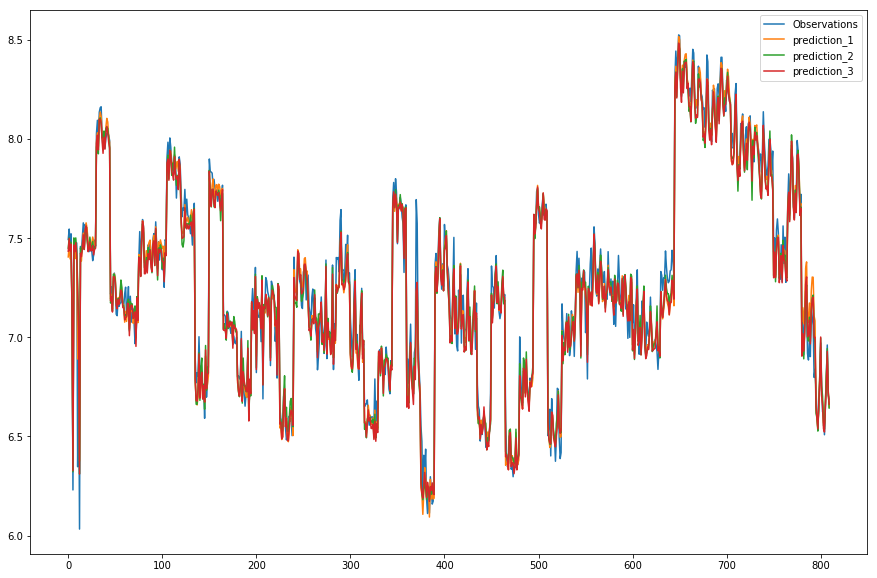

In [18]:
ts  = pd.Series(X2[target_column].values)

plt.figure(figsize=(15,10))
plt.plot(ts, label='Observations')

for c in [c for c in X2.columns if c.startswith("prediction_")]:
    ts_p = pd.Series(X2[c].values)
    plt.plot(ts_p,label=c)

plt.legend()

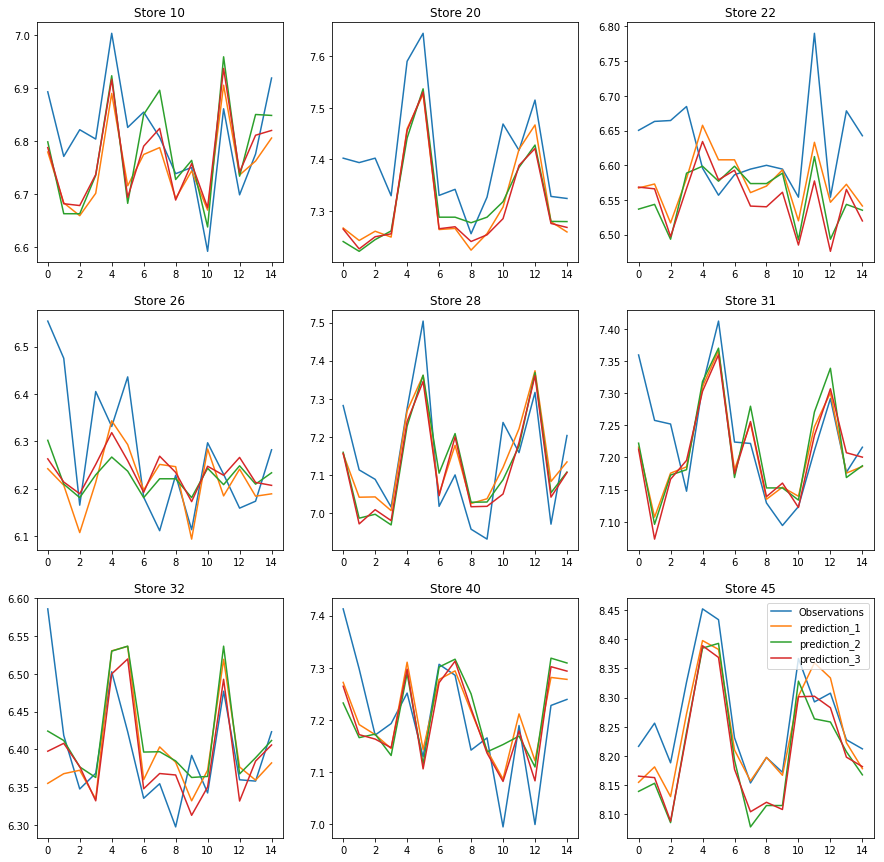

In [19]:
import random
random_stores =  sorted(u_stores[random.sample(range(len(u_stores)), 9) ])

plt.figure(figsize=(15,15))

for i in range(len(random_stores)):
    ax1 = plt.subplot(3,3,i+1)
    a_store = X2[X2.store_nbr==random_stores[i]]
    ts = pd.Series(a_store[target_column].values) # , index = a_store.date
    ax1.plot(ts, label='Observations')
    
    for c in [c for c in X2.columns if c.startswith("prediction_")]:
        ts_p = pd.Series(a_store[c].values) # , index = a_store.date
        ax1.plot(ts_p,label=c)

    plt.title('Store {}'.format(random_stores[i]))

plt.legend()

# Conclusions

- One-hot encoding works better than preprocessing.LabelEncoder()
- Categorical features are not very relevant. It is enough to keep only one (store_nbr)
- Temporal correlation is very important
- Random seeder was very relevant for the error metric

The sequentially resulting RMSEs for the method 1 (MLP) were:
- Label encoding: 0.517800
- One-hot encoding: 0.247412
- lag_7: (0.147181, 0.104493, 0.235048)
- lag_annual_exact: (0.144416, 0.103941, 0.235645)
- lag_annual_364: (0.133182, 0.084941, 0.232098)


Normalizing the target variable leads to poor performance. It shall be further analyzed. Maybe it has to do with something that is mentioned in a previous [1st place solution](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md):
"This scale information is lost in a pageviews feature, because each pageviews series independently normalized to zero mean and unit variance"


In [20]:
sales[[c for c in sales.columns if not c.startswith('store_nbr_')]].to_csv('../input/processed/sales+.csv', index=False)

# Predict transactions for the test dataset

In [21]:
## Train best method
np.random.seed(1122)
#r = BaggingRegressor(DecisionTreeRegressor(max_depth=6,max_features=0.85))   
r = MLPRegressor(hidden_layer_sizes=(3,), max_iter=100)
r.fit(X1[cols], y1)
yh2 = r.predict(X2[cols])
m = metrics.mean_squared_error(y2, yh2)**0.5
print("Error: %f" % (m))

Error: 0.081981


In [22]:
## Create initial dataset
dates_range =  pd.date_range('2017-08-16', '2017-08-31')

a = pd.DataFrame({'date':dates_range, 'key':0})
b = pd.DataFrame({'store_nbr':sorted(u_stores), 'key':0})

X3 = a.merge(b, how='outer').drop('key',1)

## Pre-processing
X3 = merge_sales(X3)
add_date_features(X3)
enable_holidays(X3)
X3 = encode_categorical_features(X3)

In [23]:
## Original data for the lag features
sales_0 = pd.read_csv('../input/transactions.csv', parse_dates=['date'])
transform_transactions(sales_0)


## Special treatment for store #52
## Since store #52 only has records from 2017-04-20, the annual lag feature will be obtained from a weekly average
s52 = sales_0[ sales_0.store_nbr==52][['date','transactions']]
s52['dow'] = s52.date.dt.dayofweek
w_trend = s52.groupby('dow').transactions.agg('mean')

## Method for creating lag features at a single day
def get_lag_features(X3, a_date):
    for index, row in X3[X3.date==a_date].iterrows():
        #print(index)
        #print(row.date)
        #print((row.date-datetime.timedelta(days=7)))
        #print(sales[(sales.store_nbr==1) & (sales.date==(row.date-datetime.timedelta(days=7)))])

        ## Get lag_7
        tmp = sales_0[(sales_0.store_nbr==row.store_nbr) & 
                      ((sales_0.date==(row.date-datetime.timedelta(days=7))) | 
                       (sales_0.date==(row.date-datetime.timedelta(days=7*2)))) ]['transactions']

        if(len(tmp)>0):
            X3.loc[index,'lag_7'] = tmp.iloc[-1]
        else:
            if row.store_nbr==52:
                X3.loc[index,'lag_annual'] = w_trend[row.dow]
            else:
                print("Missing lag_7 for : (%d,%s,%s)"% (row.store_nbr,row.date,row.date-datetime.timedelta(days=7)))
                raise Exception('debug this!')

        ## Get lag_annual
        tmp = sales_0[(sales_0.store_nbr==row.store_nbr) & 
                      ((sales_0.date==(row.date-datetime.timedelta(days=364))) | 
                       (sales_0.date==(row.date-datetime.timedelta(days=364*2)))) ]['transactions']

        if(len(tmp)>0):
            X3.loc[index,'lag_annual'] = tmp.iloc[-1]
        else:

            if row.store_nbr==52:
                X3.loc[index,'lag_annual'] = w_trend[row.dow]
            else:
                print("Missing lag_annual for : (%d,%s,%s)"% (row.store_nbr,row.date,row.date-datetime.timedelta(days=364)))
                raise Exception('debug this!')


In [24]:
cols

['dcoilwtico',
 'week',
 'dow',
 'dayofyear',
 'dayoff',
 'store_nbr_1',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_9',
 'store_nbr_10',
 'store_nbr_11',
 'store_nbr_12',
 'store_nbr_13',
 'store_nbr_14',
 'store_nbr_15',
 'store_nbr_16',
 'store_nbr_17',
 'store_nbr_18',
 'store_nbr_19',
 'store_nbr_20',
 'store_nbr_21',
 'store_nbr_22',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_28',
 'store_nbr_29',
 'store_nbr_30',
 'store_nbr_31',
 'store_nbr_32',
 'store_nbr_33',
 'store_nbr_34',
 'store_nbr_35',
 'store_nbr_36',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_39',
 'store_nbr_40',
 'store_nbr_41',
 'store_nbr_42',
 'store_nbr_43',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nbr_48',
 'store_nbr_49',
 'store_nbr_50',
 'store_nbr_51',
 'store_nbr_52',
 'store_nbr_53',
 'store_nbr_54',
 'lag_7',
 'lag_annual']

In [25]:
## Create lag_features and predict one day at a time
X3['lag_7'] = np.nan
X3['lag_annual'] = np.nan
X3['transactions'] = np.nan

## For each date: (1) Create lag_features, (2) Predict transactions
for a_date in dates_range:
    #a_date = dates_range[0]
    get_lag_features(X3, a_date) # Add lag features
    yh_3 = r.predict(X3[X3.date==a_date][cols]) # Predict
    X3.loc[X3.date==a_date, 'transactions'] = yh_3
    sales_0 = pd.concat([sales_0,X3[X3.date==a_date][['date','store_nbr','transactions']]]) # Append to historical

In [26]:
sales_0.tail()

,date,store_nbr,transactions
859,2017-08-31,50,7.753454
860,2017-08-31,51,7.325102
861,2017-08-31,52,7.636736
862,2017-08-31,53,7.142369
863,2017-08-31,54,6.599633


### Check predictions

In [27]:
sales_0.to_csv('../input/processed/sales_completed.csv', index=False)

In [28]:
sales[ (sales.store_nbr==21) & (sales.date=='2016-01-05') ].head()

,date,store_nbr,transactions,city,state,type,cluster,dcoilwtico,week,dow,...,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,lag_7,lag_annual
59366,2016-01-05,21,7.044905,Santo Domingo,Santo Domingo de los Tsachilas,B,6.0,35.97,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.167809,6.985741


In [29]:
tmp = pd.read_csv('../input/transactions.csv', parse_dates=['date'])

In [30]:
tmp[ (tmp.store_nbr==21) & (tmp.date=='2016-01-05') ].head()

,date,store_nbr,transactions
52462,2016-01-05,21,1146
